In [1]:
import functools
import json
import math
import pandas as pd
import pennylane as qml
import pennylane.numpy as np
import scipy

In [2]:
def generator_info(operator):
    """Provides the generator of a given operator.

    Args:
        operator (qml.ops): A PennyLane operator

    Returns:
        (qml.ops): The generator of the operator.
        (float): The coefficient of the generator.
    """
    gen = qml.generator(operator, format="observable")
    return gen.ops[0], gen.coeffs[0]

In [3]:
def derivative(op_order, params, diff_idx, wires, measured_wire):
    """A function that calculates the derivative of a circuit w.r.t. one parameter.

    NOTE: you cannot use qml.grad in this function.

    Args:
        op_order (list(int)):
            This is a list of integers that defines the circuit in question.
            The entries of this list correspond to dictionary keys to op_dict.
            For example, [1,0,2] means that the circuit in question contains
            an RY gate, an RX gate, and an RZ gate in that order.

        params (np.array(float)):
            The parameters that define the gates in the circuit. In this case,
            they're all rotation angles.

        diff_idx (int):
            The index of the gate in the circuit that is to be differentiated
            with respect to. For instance, if diff_idx = 2, then the derivative
            of the third gate in the circuit will be calculated.

        wires (list(int)):
            A list of wires that each gate in the circuit will be applied to.

        measured_wire (int):
            The expectation value that needs to be calculated is with respect
            to the Pauli Z operator. measured_wire defines what wire we're
            measuring on.

    Returns:
        float: The derivative evaluated at the given parameters.
    """
    op_dict = {0: qml.RX, 1: qml.RY, 2: qml.RZ}
    dev = qml.device("default.qubit", wires=2)

    obs = qml.PauliZ(measured_wire)
    operator = op_dict[op_order[diff_idx]](params[diff_idx], wires[diff_idx])
    gen, coeff = generator_info(operator)

    @qml.qnode(dev)
    def circuit_bra1():

        # Put your code here #
        
        for i, (d, p, w) in enumerate(zip(op_order, params, wires)):
            if i==diff_idx:
                if d == 0:
                    qml.PauliX(w)
                    qml.RX(p, wires=w)
                elif d==1:
                    qml.PauliY(w)
                    qml.RY(p, wires=w)
                elif d==2:
                    qml.PauliZ(w)
                    qml.RZ(p, wires=w)
            else:
                if d==0:
                    qml.RX(p, wires=w)
                elif d==1:
                    qml.RY(p, wires=w)
                elif d==2:
                    qml.RZ(p, wires=w)

        return qml.state()

    @qml.qnode(dev)
    def circuit_ket1():

        # Put your code here #
        for d, p, w in zip(op_order, params, wires):
            if d==0:
                qml.RX(p, wires=w)
            elif d==1:
                qml.RY(p, wires=w)
            elif d==2:
                qml.RZ(p, wires=w)
        
        qml.PauliZ(measured_wire)
        
        return qml.state()

    @qml.qnode(dev)
    def circuit_bra2():

        # Put your code here #
#         for d, p, w in zip(op_order, params, wires):
#             if d==0:
#                 qml.RX(p, wires=w)
#             elif d==1:
#                 qml.RY(p, wires=w)
#             elif d==2:
#                 qml.RZ(p, wires=w)
        
#         qml.PauliZ(measured_wire)
        
        return qml.state()

    @qml.qnode(dev)
    def circuit_ket2():

        # Put your code here #
#         for i, (d, p, w) in enumerate(zip(op_order, params, wires)):
#             if i==diff_idx:
#                 if d == 0:
#                     qml.PauliX(w)
#                     qml.RX(p, wires=w)
#                 elif d==1:
#                     qml.PauliY(w)
#                     qml.RY(p, wires=w)
#                 elif d==2:
#                     qml.PauliZ(w)
#                     qml.RZ(p, wires=w)
#             else:
#                 if d==0:
#                     qml.RX(p, wires=w)
#                 elif d==1:
#                     qml.RY(p, wires=w)
#                 elif d==2:
#                     qml.RZ(p, wires=w)

        return qml.state()

    bra1 = circuit_bra1()*1j
    ket1 = circuit_ket1()
    bra2 = ket1#circuit_bra2()
    ket2 = bra1#circuit_ket2()*1j

    result = (np.vdot(bra1, ket1) + np.vdot(bra2, ket2))*coeff
#     print(np.vdot(bra1, ket1), np.vdot(bra2, ket2), coeff)
#     print(result)
    return  result.real
    # Put your code here #


In [4]:

# These functions are responsible for testing the solution.

def run(test_case_input: str) -> str:
    op_order, params, diff_idx, wires, measured_wire = json.loads(test_case_input)
    params = np.array(params, requires_grad=True)
    der = derivative(op_order, params, diff_idx, wires, measured_wire)
    return str(der)

def check(solution_output: str, expected_output: str) -> None:
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    assert np.allclose(
        solution_output, expected_output, rtol=1e-4
    ), "Your derivative isn't quite right!"


test_cases = [['[[1,0,2,1,0,1], [1.23, 4.56, 7.89, 1.23, 4.56, 7.89], 0, [1, 0, 1, 1, 1, 0], 1]', '-0.2840528']]

for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[[1,0,2,1,0,1], [1.23, 4.56, 7.89, 1.23, 4.56, 7.89], 0, [1, 0, 1, 1, 1, 0], 1]'...
Correct!


In [42]:
op = qml.generator(qml.RX(1, 0), format='observable')
op.ops[0], op.coeffs[0]

(PauliX(wires=[0]), -0.5)

In [15]:
isinstance(op, qml.operation.Operator)

True

In [62]:
dev = qml.device("default.qubit", wires=2)
@qml.qnode(dev)
def cirq():
    qml.RY(0.1, 0)
    qml.RY(0.1, 1)
    qml.adjoint(qml.PauliX(0))
    
    #return qml.expval(qml.PauliZ(0))
    return qml.state()

/tmp/ipykernel_94141/1235263225.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


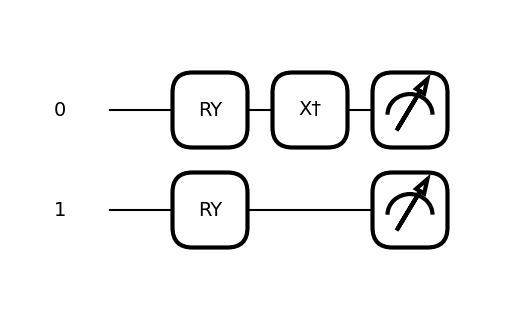

In [63]:
fig, ax = qml.draw_mpl(cirq)()
fig.show()

In [67]:
-1j*cirq()

tensor([0.-0.04991671j, 0.-0.00249792j, 0.-0.99750208j, 0.-0.04991671j], requires_grad=True)

In [71]:
qml.adjoint(qml.PauliZ(0))

Adjoint(PauliZ(wires=[0]))